# <span style="color:orange"> Laboratorio di Simulazione Numerica </span>
## <span style="color:orange"> Esercitazione 12 </span>

### Paolo Panatti (12606A)

### <font color="blue"> Esercizio 12.1

#### Obiettivo:
Addestrare una rete neurale profonda (DNN) per svolgere un problema di **classificazione**, che consiste nel riconoscimento delle dieci cifre scritte a mano presenti nel dataset MNIST. In particolare, confrontare le performance di più ottimizzatori diversi.

Il dataset MNIST contiene $70000$ cifre scritte a mano, sotto forma di immagini in scala di grigi di dimensione $28 \times 28$ pixel. Ogni pixel può assumere un valore di intensità compreso tra $0$ e $256$.

Prima di tutto, ho importato i dati, già suddivisi nei due set di training ($60000$ dati) e di validazione ($10000$ dati), e li ho formattati in modo da poterli utilizzare come input e label di una DNN. Più in dettaglio, ho trasformato le immagini, che sono a tutti gli effetti delle matrici $28 \times 28$, in vettori di $784$ elementi e le etichette numeriche in vettori tali che tutti gli elementi sono $0$, tranne quello in posizione corrispondente all'etichetta, che vale $1$.

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [7]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape before reshaping:', X_train.shape)
print('Y_train shape before to_categorical:', Y_train.shape)
print()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape after reshaping:', X_train.shape)
print('X_test shape after reshaping:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('X_train shape after reshaping:', X_train.shape)
print('Y_train shape after to_categorical:', Y_train.shape)

X_train shape before reshaping: (60000, 28, 28)
Y_train shape before to_categorical: (60000,)

X_train shape after reshaping: (60000, 784)
X_test shape after reshaping: (10000, 784)

X_train shape after reshaping: (60000, 784)
Y_train shape after to_categorical: (60000, 10)


A questo punto ho creato un modello costituito da tre layer di tipo Dense: due nascosti, contenenti rispettivamente $400$ e $100$ neuroni, il primo dei quali riceve l'input, e uno di output da $10$ neuroni (il numero di neuroni di output deve essere pari al numero di classi). Ho aggiunto inoltre un layer di Dropout, che durante la fase di addestramento disattiva casualmente metà dei neuroni del layer precedente. L'effetto è quello di ridurre l'overfitting e migliorare la capacità di generalizzazione del modello. I due layer nascosti hanno funzione di attivazione ReLU (Rectified Linear Unit), mentre l'ultimo layer utilizza la funzione softmax, che converte gli output in probabilità e quindi permette di selezionare la classe identificata con maggior probabilità. Come loss function ho scelto la categorical crossentropy, adatta al problema e alla tipologia di output in questione, e come metrica, invece, l'accuracy, che misura la percentuale di dati classificati correttamente. Per quanto riguarda l'ottimizzatore, infine, ho deciso di testarne tre differenti:
- *SGD* (Stochastic Gradient Descent): aggiorna i parametri in direzione opposta al gradiente, calcolato su un piccolo insieme di dati selezionati casualmente anziché sull'intero dataset.
- *AdaGrad* (Adaptive Gradient): ottimizzatore con rate di apprendimento specifici per ogni parametro, che vengono regolati in base a quanto frequentemente il parametro viene aggiornato (più un parametro riceve aggiornamenti, più piccolo è il suo rate di apprendimento).
- *Adamax*: variante di Adam che regola i rate di apprendimento usando la stima del primo momento e la norma infinito dei gradienti.

In tutti e tre i casi ho allenato la rete per un numero totale di epoche pari a $30$, monitorando l'andamento della loss e della metrica, e successivamente ho valutato la performance dei tre modelli sui dati di validazione.


Addestramento con ottimizzatore: SGD

Test loss: 0.06527107954025269, Test accuracy: 0.9797999858856201



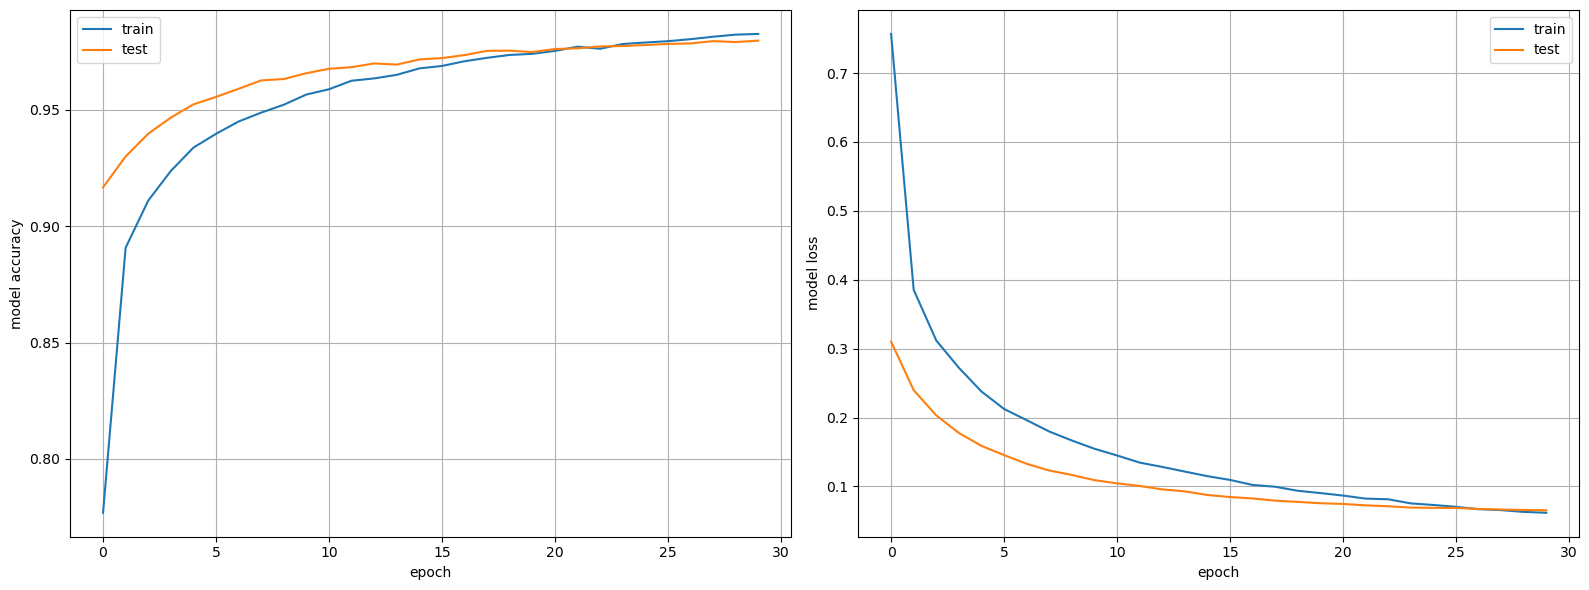

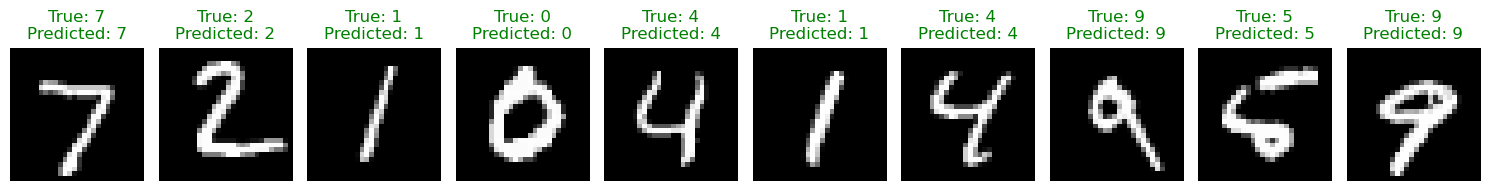


Addestramento con ottimizzatore: Adagrad

Test loss: 0.1783377081155777, Test accuracy: 0.9476000070571899



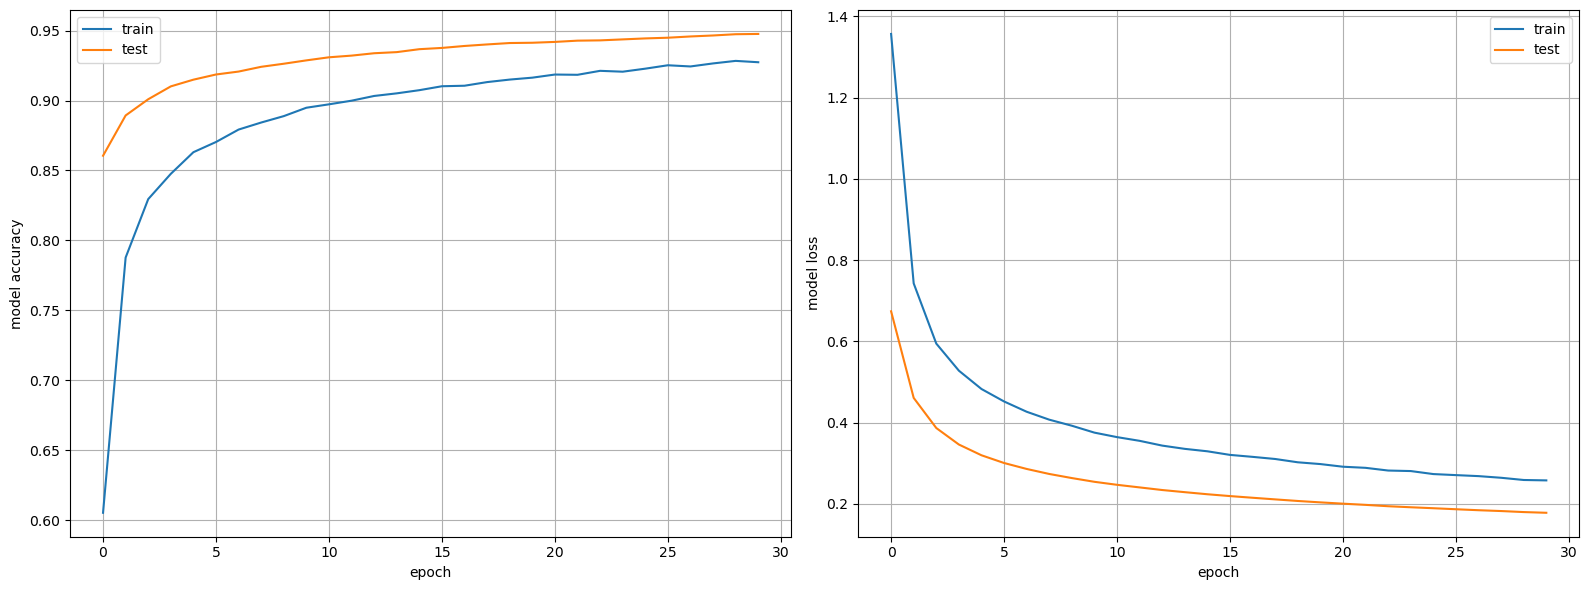

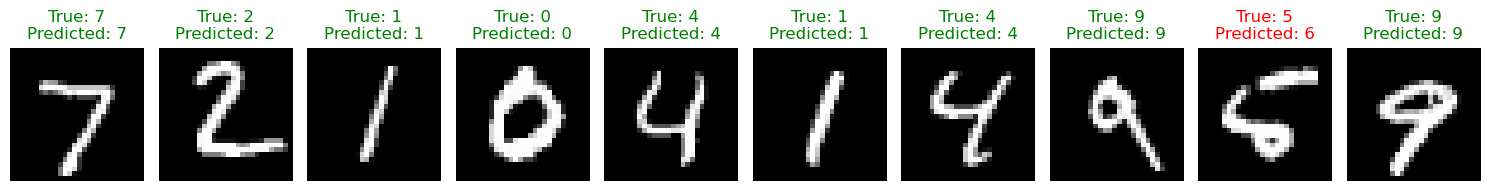


Addestramento con ottimizzatore: Adamax

Test loss: 0.06453825533390045, Test accuracy: 0.9843999743461609



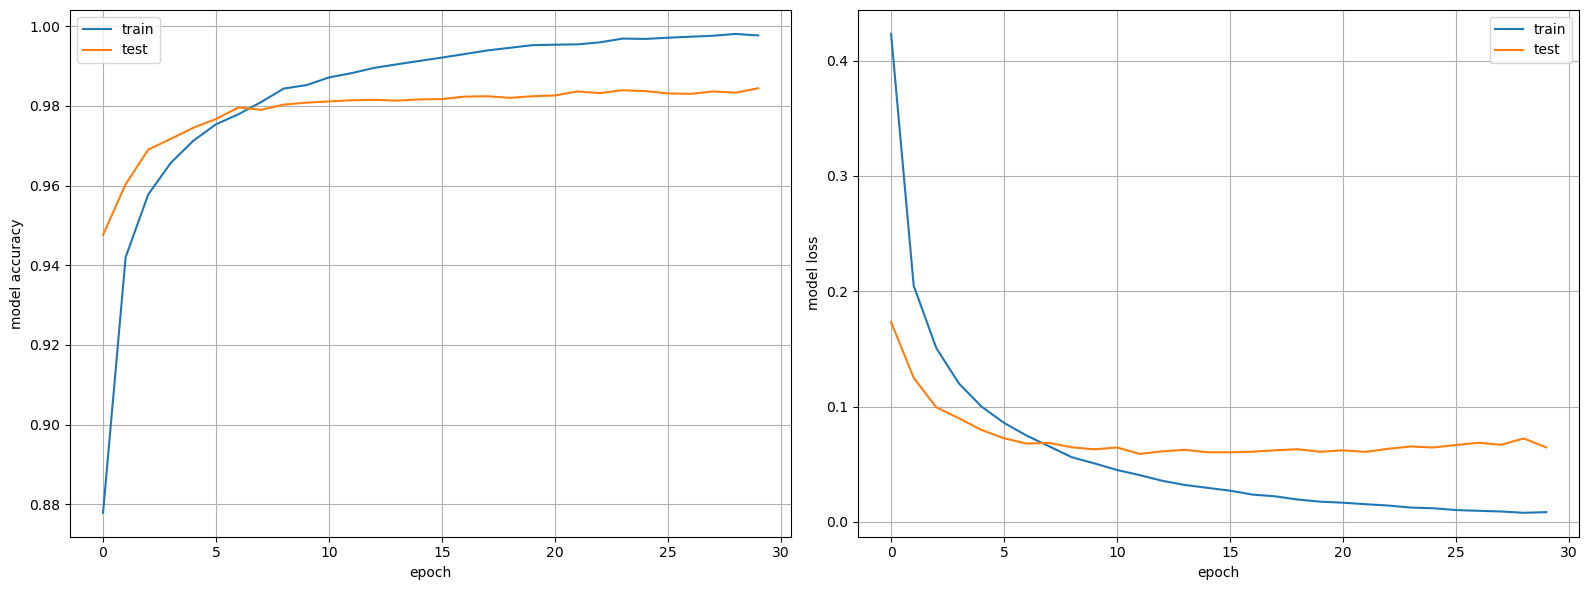

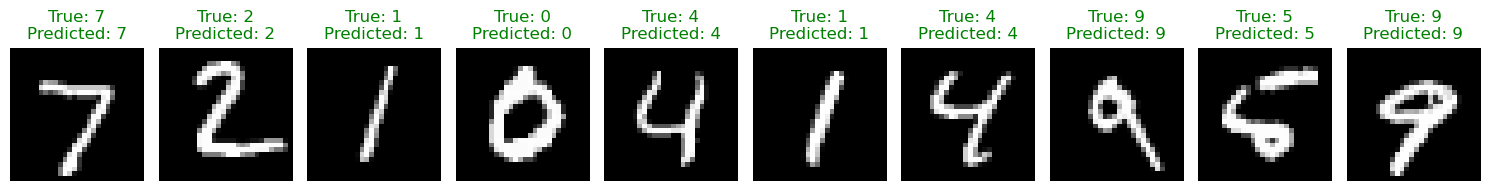

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400, input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Lista degli ottimizzatori da testare
optimizers = [
    ('SGD', SGD()),
    ('Adagrad', Adagrad()),
    ('Adamax', Adamax())
]

# training parameters
batch_size = 32
epochs = 30 # fare almeno una trentina di epoche!

for name, opt in optimizers:
    # create the model
    model_DNN=create_DNN()
    # compile the model
    model_DNN.compile(optimizer=opt,
                      loss=keras.losses.categorical_crossentropy,
                      metrics=['acc'])
    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              verbose=0,
              validation_data=(X_test, Y_test))

    print()
    print("="*60)
    print(f"Addestramento con ottimizzatore: {name}")
    print("="*60)
    
    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=0)
    # print performance
    print(f"\nTest loss: {score[0]}, Test accuracy: {score[1]}")
    print()
    
    # look into training history
    plt.figure(figsize=(16, 6))
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.grid(True)
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # predizioni
    predictions = model_DNN.predict(X_test, verbose=0)
    X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    plt.figure(figsize=(15, 15))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')
        true_label = np.argmax(Y_test[i])
        predicted_label = np.argmax(predictions[i])
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Confrontando i risultati ottenuti possiamo concludere che in questo caso il miglior ottimizzatore è Adamax, in quanto converge più rapidamente, raggiungendo una loss più bassa e un'accuracy più alta rispetto agli altri.

### <font color="blue"> Esercizio 12.2

#### Obiettivo:
Addestrare una rete neurale convoluzionale (CNN) per svolgere lo stesso problema dell'esercizio precedente.

Una **rete neurale convoluzionale** è una particolare architettura invariante sotto traslazioni, che rispetta la località dei dati di input. Grazie alla sua capacità di catturare strutture spaziali rilevanti, rappresenta la scelta più efficace quando si affrontano problemi di riconoscimento di immagini. Essa è composta da un alternarsi di layer convoluzionali e di pooling: un layer convoluzionale calcola la convoluzione dell'immagine con una serie di filtri che scorrono sui vari pixel, mentre un layer di pooling riduce le dimensioni spaziali mantenendo le informazioni più rilevanti. Questi layer sono poi generalmente susseguiti da layer standard di tipo Dense e da un classificatore, come ad esempio un layer con funzione di attivazione softmax.

Nel nostro caso, dopo aver riformattato i dati come segue, ho realizzato un modello costituito da un primo layer convoluzionale con $6$ filtri di dimensione $5 \times 5$ e stride $s=1$ (i filtri vengono traslati di un pixel alla volta) e con funzione di attivazione ReLU, da un layer di max-pooling che divide l'input in regioni $2 \times 2$ e per ciascuna di esse mantiene solamente il valore massimo, da un secondo layer convoluzionale simile al primo ma questa volta con $16$ filtri seguito da un altro layer di max-pooling, da un layer di tipo Flatten necessario per linearizzare prima di passare ad un layer di tipo Dense contenente $128$ neuroni con funzione di attivazione ReLU e, infine, da un ultimo layer di $10$ neuroni dotati di funzione di attivazione softmax. Ho aggiunto, inoltre, un layer di Dropout con rate $0.5$. Come ottimizzatore ho scelto Adamax, mentre la loss function e la metrica sono le stesse dell'esercizio precedente. Per allenare la rete ho deciso di utilizzare $30$ epoche.

In [28]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [36]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add layers
    model.add(Conv2D(6, kernel_size=(5, 5), strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model
    model.compile(optimizer='Adamax',
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['acc'])
    model.summary()
    return model

In [38]:
# training parameters
batch_size = 32
epochs = 30

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history_CNN = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=1,
          validation_data=(X_test, Y_test))

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,758 (143.59 KB)

 Trainable params: 36,758 (143.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.7266 - loss: 0.8704 - val_acc: 0.9597 - val_loss: 0.1312
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9388 - loss: 0.2070 - val_acc: 0.9723 - val_loss: 0.0846
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9565 - loss: 0.1487 - val_acc: 0.9792 - val_loss: 0.0659
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - acc: 0.9635 - loss: 0.1237 - val_acc: 0.9812 - val_loss: 0.0569
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9677 - loss: 0.1085 - val_acc: 0.9839 - val_loss: 0.0489
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9728 - loss: 0.0941 - val_acc: 0.9859 - val_loss: 0.0442
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9738 - loss: 0.0870 - val_acc: 0.9870 - val_loss: 0.0406
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9772 - loss: 0.0787 - val_acc: 0.9879 - val_loss: 0.0381
Epoch 9/30
1875/1875 ━━━

In [40]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9892 - loss: 0.0366

Test loss: 0.027760135009884834
Test accuracy: 0.9912999868392944


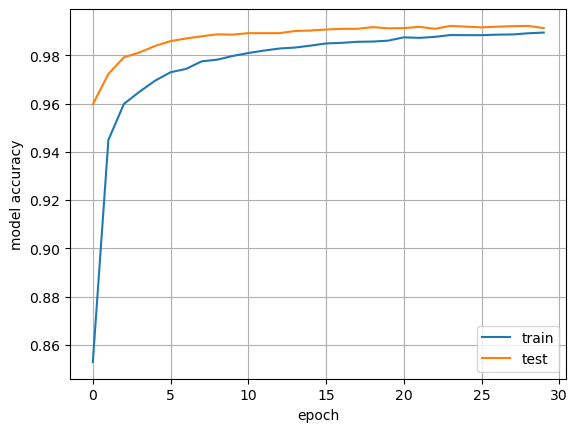

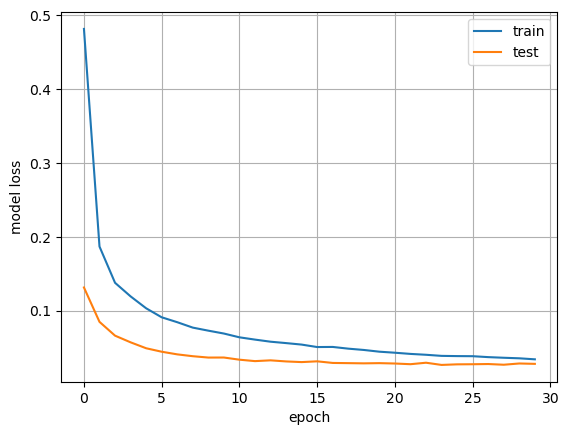

In [42]:
# look into training history

# summarize history for accuracy
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(True)
plt.show()

# summarize history for loss
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   


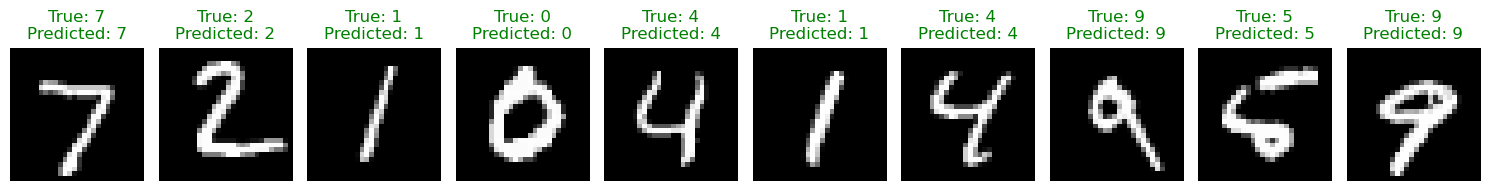

In [44]:
# predizioni
predictions = model_CNN.predict(X_test, verbose=1)
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')
    true_label = np.argmax(Y_test[i])
    predicted_label = np.argmax(predictions[i])
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

Il modello ha raggiunto un'accuracy sui dati di test del $99,13\%$!

### <font color="blue"> Esercizio 12.3

#### Obiettivo:
Testare le due reti neurali addestrate (DNN e CNN) su un campione di $10$ cifre scritte a mano personalmente utilizzando l'applicazione `gimp`.

Innanzitutto carico il dataset.

In [63]:
from PIL import Image

images = []

# importo le 10 immagini
for n in range(10):
    digit_filename = f"numero{n}.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix = digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]
    data /= 255
    images.append(data)

images = np.array(images)

Predizioni della DNN allenata con ottimizzatore Adamax:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


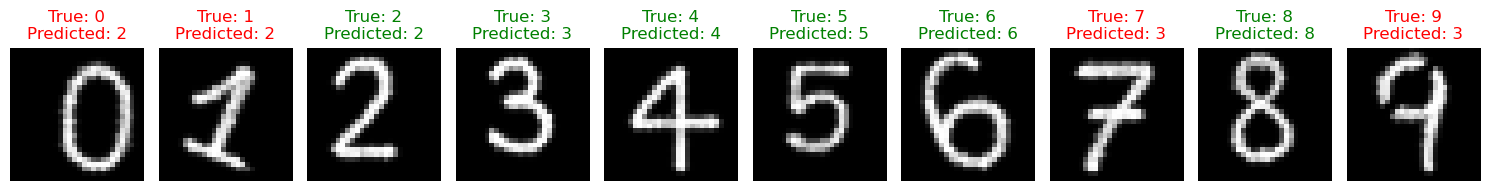

In [65]:
X_pred = images.reshape(images.shape[0], xdim*ydim)
pred_DNN = model_DNN.predict(X_pred)

plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i], cmap='gray')
    true_label = i
    predicted_label = np.argmax(pred_DNN[i])
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

Predizioni della CNN:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


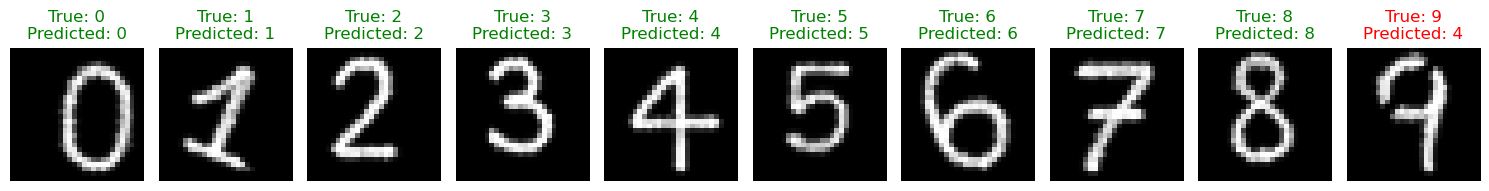

In [67]:
X_pred = images.reshape(images.shape[0], ydim, xdim, 1)
pred_CNN = model_CNN.predict(X_pred)

plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i], cmap='gray')
    true_label = i
    predicted_label = np.argmax(pred_CNN[i])
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

Osserviamo che le prestazioni della CNN sono decisamente migliori rispetto a quelle della DNN. Riesce a riconoscere persino le cifre non perfettamente centrate ($0$) o leggermente ruotate ($1$ e $6$), ma fa fatica se sono presenti dei difetti ($9$).